# EDA project

## Load libraries and datasets

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm

import sys
# append the path of the parent directory
sys.path.append("..")
from lib.functions import *


In [47]:
clients_raw = pd.read_csv('../data/raw/df_final_demo.txt')
events_1_raw = pd.read_csv('../data/raw/df_final_web_data_pt_1.txt')
events_2_raw = pd.read_csv('../data/raw/df_final_web_data_pt_2.txt')
test_raw = pd.read_csv('../data/raw/df_final_experiment_clients.txt')

## Data cleaning and exploration

### Clients

In [48]:
clients = clients_raw.copy()
clients.head()

,client_id,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth
0,836976,6.0,73.0,60.5,U,2.0,45105.30,6.0,9.0
1,2304905,7.0,94.0,58.0,U,2.0,110860.30,6.0,9.0
2,1439522,5.0,64.0,32.0,U,2.0,52467.79,6.0,9.0
3,1562045,16.0,198.0,49.0,M,2.0,67454.65,3.0,6.0
4,5126305,12.0,145.0,33.0,F,2.0,103671.75,0.0,3.0


In [49]:
clients.info()
# there are some null values. 
# client_id and gender are the only categorical columns. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70609 entries, 0 to 70608
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         70609 non-null  int64  
 1   clnt_tenure_yr    70595 non-null  float64
 2   clnt_tenure_mnth  70595 non-null  float64
 3   clnt_age          70594 non-null  float64
 4   gendr             70595 non-null  object 
 5   num_accts         70595 non-null  float64
 6   bal               70595 non-null  float64
 7   calls_6_mnth      70595 non-null  float64
 8   logons_6_mnth     70595 non-null  float64
dtypes: float64(7), int64(1), object(1)
memory usage: 4.8+ MB


In [50]:
# remove null values

clients.isnull().sum().sort_values(ascending = False)
clients[clients.clnt_age.isna()]

# it seems like there are 14 rows with lots of null values and 1 row where the age is missing. 
# This is an insignificant amount of data (having >70000 valid data points) 
# We can savely remove these data. 

clients.dropna(inplace=True)

In [51]:
# look for duplicates
clients.duplicated().sum()

# there are no duplicated values. 

np.int64(0)

In [52]:
# assign correct data types

clients.dtypes

# create 2 lists for categorial vs numerical columns. 
clients_num = list(clients.select_dtypes("number").columns)
clients_num.remove('client_id')
clients_cat = ['client_id', 'gendr']

len(clients.columns) == len (clients_num + clients_cat)

# many numerical columns look like int but have type float. Let's assign the correct type.
int_cols = ['clnt_tenure_yr', 'clnt_tenure_mnth', 'num_accts', 'calls_6_mnth', 'logons_6_mnth']
clients[int_cols] = clients[int_cols].astype('int64')


In [53]:
# Explore categorial columns. 
# there are for possible values for gender. We assume that 'U' stands for unknown. 'X' may stand for non binary. 
clients.gendr.value_counts()

gendr
U    24122
M    23724
F    22745
X        3
Name: count, dtype: int64

In [54]:
# Explore numerical columns. 

clients[clients_num].describe()

,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,num_accts,bal,calls_6_mnth,logons_6_mnth
count,70594.000000,70594.000000,70594.000000,70594.000000,7.059400e+04,70594.000000,70594.000000
mean,12.053007,150.659999,46.442240,2.255532,1.474467e+05,3.382469,5.566720
std,6.871850,82.090264,15.591273,0.535000,3.015106e+05,2.236595,2.353296
min,2.000000,33.000000,13.500000,1.000000,1.378942e+04,0.000000,1.000000
25%,6.000000,82.000000,32.500000,2.000000,3.734660e+04,1.000000,4.000000
50%,11.000000,136.000000,47.000000,2.000000,6.333459e+04,3.000000,5.000000
75%,16.000000,192.000000,59.000000,2.000000,1.375461e+05,6.000000,7.000000
max,62.000000,749.000000,96.000000,8.000000,1.632004e+07,7.000000,9.000000


In [55]:
# some values are incoherent (the tenure is bigger than the age). We can remove them.
clients = clients[clients['clnt_age']>clients['clnt_tenure_yr']]

### Events

In [56]:
# there are two datasets for events. We want to merge them. 
events_1_raw.shape
events_2_raw.shape

# both columns have the same columns, we can savely concat them.
events = pd.concat([events_1_raw, events_2_raw])
events.head()

,client_id,visitor_id,visit_id,process_step,date_time
0,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:27:07
1,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:26:51
2,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:19:22
3,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:19:13
4,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:18:04


In [57]:
events.info()
# the column types seem more or less correct and there are no null values. 

<class 'pandas.core.frame.DataFrame'>
Index: 755405 entries, 0 to 412263
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   client_id     755405 non-null  int64 
 1   visitor_id    755405 non-null  object
 2   visit_id      755405 non-null  object
 3   process_step  755405 non-null  object
 4   date_time     755405 non-null  object
dtypes: int64(1), object(4)
memory usage: 34.6+ MB


In [58]:
# remove duplicates. 

events.duplicated().sum()   
# there are many duplicated events. Let's remove them
events.drop_duplicates(inplace=True)

In [59]:
# data types. 
events_categorical = ['client_id', 'visitor_id', 'visit_id', 'process_step']

# ordinal: process_step
events_numerical = ['date_time']

# let's convert date_time to datetime. 
events['date_time'] = pd.to_datetime(events['date_time'])

In [60]:
# categorial columns exploration.
events['process_step'].value_counts()

process_step
start      234999
step_1     162797
step_2     132750
step_3     111589
confirm    102506
Name: count, dtype: int64

In [61]:
events_categorical = ['client_id', 'visitor_id', 'visit_id', 'process_step']
# ordinal: process_step
events_numerical = ['date_time']

### Test

In [62]:
test = test_raw.copy()
test.head()

,client_id,Variation
0,9988021,Test
1,8320017,Test
2,4033851,Control
3,1982004,Test
4,9294070,Control


In [63]:
test.info()

# there are null values in the 'Variation' column. We assume these clients didn't participate in the experiment.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70609 entries, 0 to 70608
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   client_id  70609 non-null  int64 
 1   Variation  50500 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [64]:
# remove nulls. 
# we will remove the clients that didn't participate in the experiment.
test = test.dropna()

In [65]:
test

,client_id,Variation
0,9988021,Test
1,8320017,Test
2,4033851,Control
3,1982004,Test
4,9294070,Control
...,...,...
50495,393005,Control
50496,2908510,Control
50497,7230446,Test
50498,5230357,Test


## Univariate Analysis

### Clients

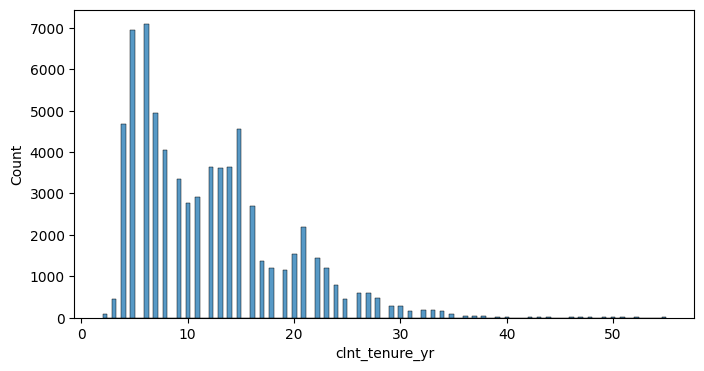

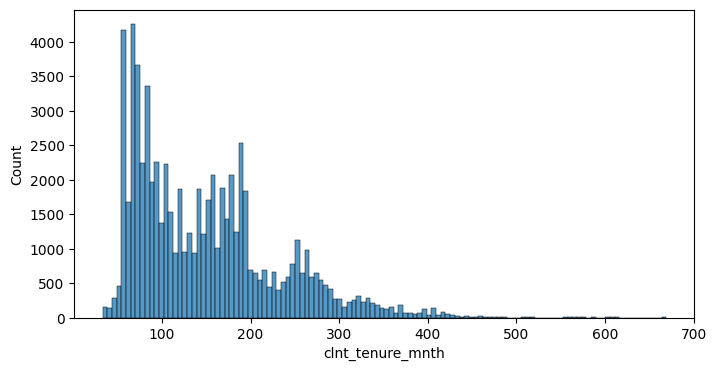

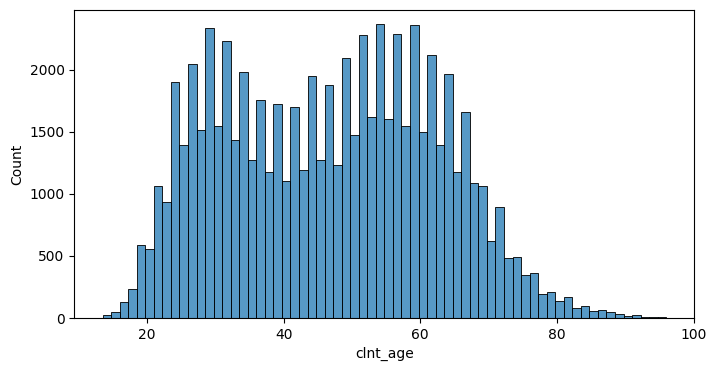

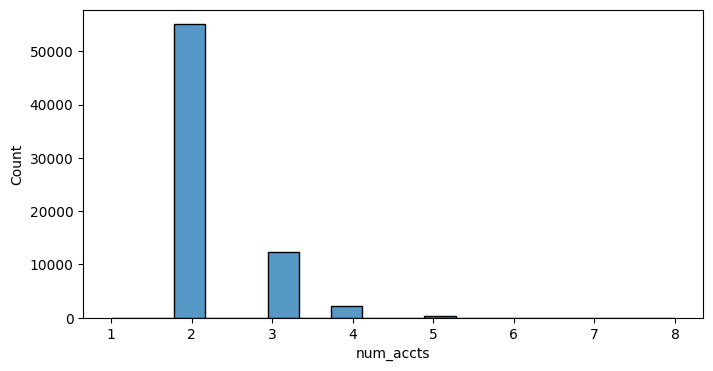

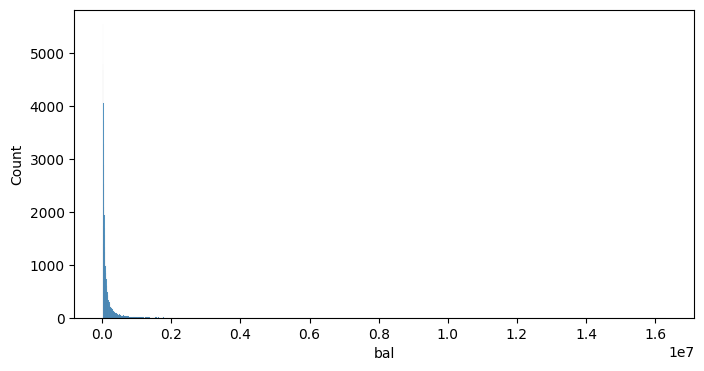

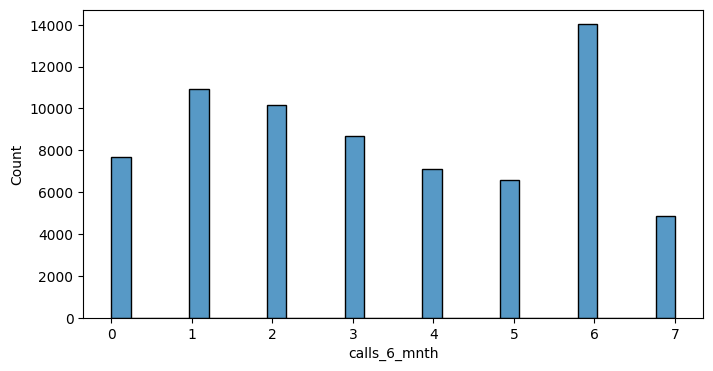

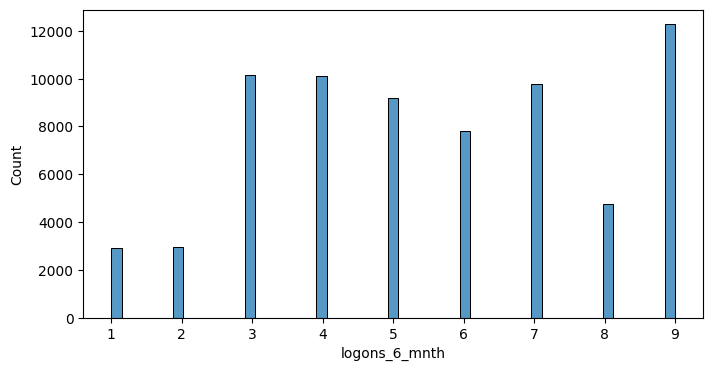

In [66]:
# visualise distributions for numerical columns.  

for col in clients_num:
    plt.figure(figsize=(8, 4))
    sns.histplot(x=clients[col])
    plt.show()


/var/folders/yf/ydfr37g56sb7b4mncpm76gk00000gn/T/ipykernel_72976/3211288094.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(c['bal'], color='skyblue', shade=True)


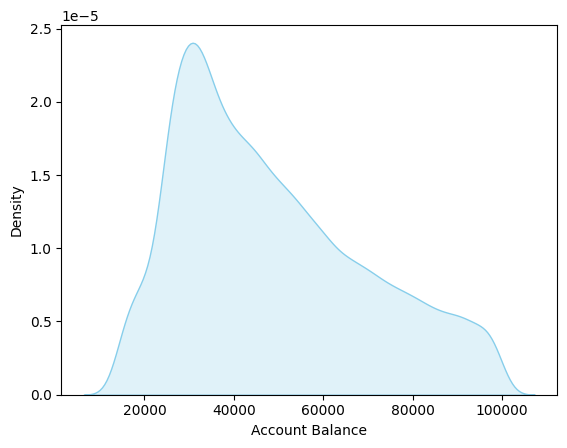

In [67]:
c = clients[clients['bal']<100000]
sns.kdeplot(c['bal'], color='skyblue', shade=True)
plt.xlabel('Account Balance')
plt.show()

### Events

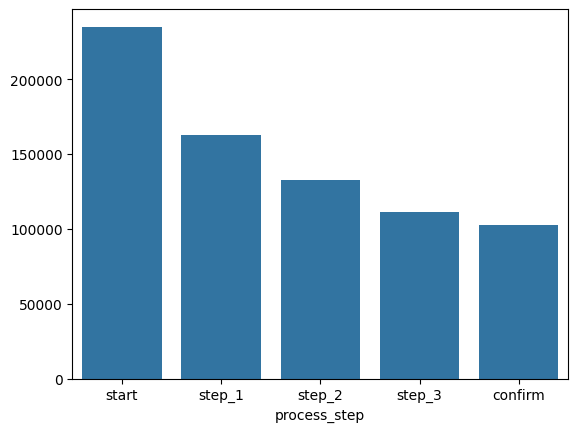

In [68]:
# Let's see how far in the funnel the users get

frequency_table = events["process_step"].value_counts()
frequency_table 

sns.barplot(x=frequency_table.index, y=frequency_table.values);

plt.show()

### Most active clients

In [69]:
# We will count the number of events to identify the most active clients. 
client_event_counts = events['client_id'].value_counts()
clients_events = pd.merge(clients, client_event_counts, on="client_id", how="inner")

In [70]:
# order clients by event_count
clients_events = clients_events.sort_values(by='count', ascending=False).reset_index(drop=True)

In [71]:
# Identify the top 10% of active clients (this can be changed to any other percentage if needed)
clients_events.head(int(len(clients_events) * 0.10))


,client_id,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth,count
0,2128341,12,153,52.5,F,2,176731.72,3,3,81
1,9800867,22,266,62.0,U,2,24449.73,6,6,75
2,465007,14,179,73.0,M,3,126442.72,6,9,72
3,9638063,33,406,78.0,F,2,87107.79,6,9,71
4,3539274,23,282,67.5,M,4,2797594.12,7,7,69
...,...,...,...,...,...,...,...,...,...,...
6993,6766787,15,183,54.5,F,2,175004.69,0,3,11
6994,3203669,20,250,58.0,F,2,199017.72,4,7,11
6995,354470,11,142,44.0,M,2,403894.16,2,5,11
6996,2554940,26,318,34.0,F,2,51415.02,0,3,11


In [72]:
# we will signal those clients that are most active (top 10%).

clients_events['most_active'] = clients_events['client_id'].isin(clients_events['client_id'].head(int(len(clients_events) * 0.10)))

top_client_info = clients_events[clients_events['most_active'] == True]

In [73]:
age_analysis = top_client_info['clnt_age'].describe()
tenure_years_analysis = top_client_info['clnt_tenure_yr'].describe()
tenure_months_analysis = top_client_info['clnt_tenure_mnth'].describe()

print("Age Analysis:\n", age_analysis)
print("\nTenure (Years) Analysis:\n", tenure_years_analysis)
print("\nTenure (Months) Analysis:\n", tenure_months_analysis)

Age Analysis:
 count    6998.000000
mean       51.973564
std        15.450348
min        14.500000
25%        41.000000
50%        54.500000
75%        63.000000
max        94.000000
Name: clnt_age, dtype: float64

Tenure (Years) Analysis:
 count    6998.000000
mean       12.823092
std         7.309947
min         2.000000
25%         6.000000
50%        12.000000
75%        17.000000
max        52.000000
Name: clnt_tenure_yr, dtype: float64

Tenure (Months) Analysis:
 count    6998.000000
mean      159.785367
std        87.480323
min        33.000000
25%        83.000000
50%       145.000000
75%       211.000000
max       631.000000
Name: clnt_tenure_mnth, dtype: float64


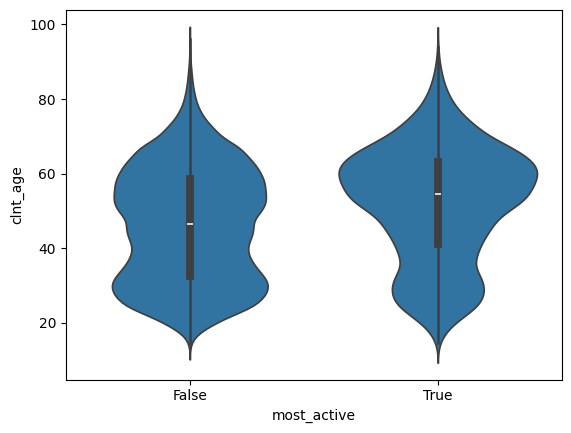

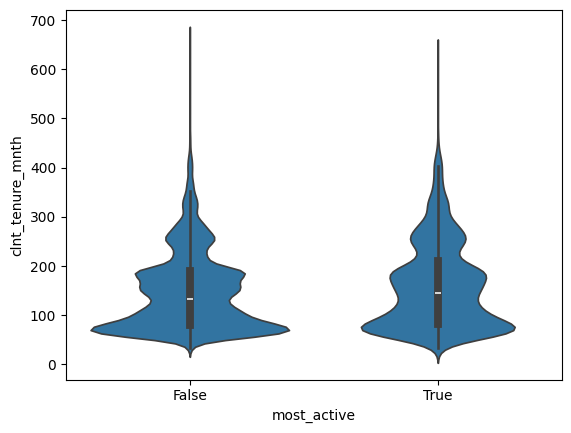

In [74]:
# Let's take a look at the distribution for age and tenure. 
for col in ['clnt_age', 'clnt_tenure_mnth']:
    sns.violinplot(data=clients_events, x='most_active', y=col)
    plt.show()

# the median age and tenure is higher for the most active clients.

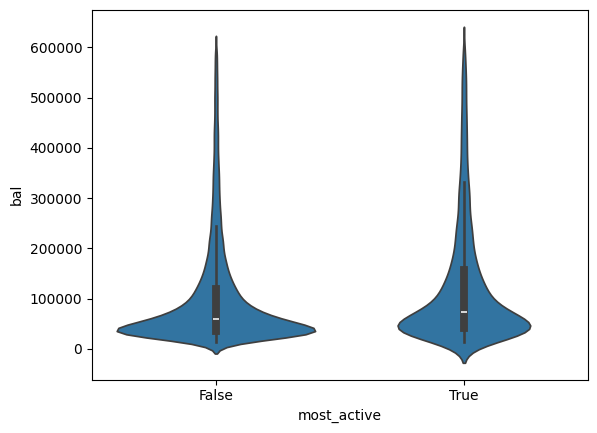

In [75]:
# There are very high outliers in balance. We will filter them out to see the distribution
sns.violinplot(data = clients_events [clients_events['bal'] < 600000], x='most_active', y='bal')
plt.show()

# the median balance is higher for most active users. 

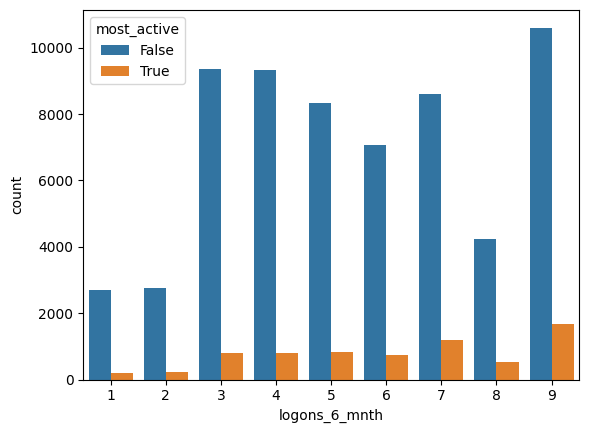

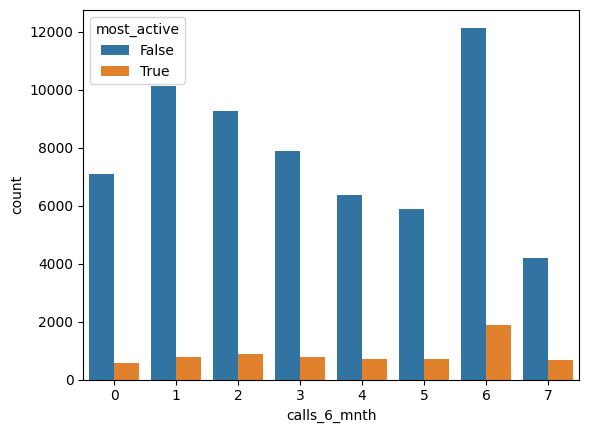

In [76]:
for col in ['logons_6_mnth', 'calls_6_mnth']:
    sns.countplot(data=clients_events, x=col, hue='most_active')
    plt.show()

## Behavior analysis

We want to analyse if the test affected the user behaviour. 
With that goal in mind we will some metrics that will later be used to compare the behaviour of those users that participated in the test o that were in the control group. 

**Key performance indicator**: 
- Users that "confirmed" the operation. 
Our main goal is to optimise the funnel to increase this metric. We will label this as "conversion". 

**Other metrics**: 
- Avg. visit duration. 
- Step duration. 
- Total errors. 
- Step errors. 
- Drop off step. 

### Calculate new metrics

In [77]:
import numpy as np
# Duration and step metrics. 

# turn the step column into a numeric value. 
events['init_step'] = events['process_step'].replace({'start': 0, 'step_1': 1, 'step_2': 2, 'step_3': 3, 'confirm': 4})

# shift the table to calculate the time spent in each step and the next step.
# we need to sort by visit_id and date_time first: 
events = events.sort_values(['visit_id', 'date_time']).reset_index()
events[['end_time', 'next_step']] = events[['visit_id', 'date_time','init_step']].groupby('visit_id').shift(-1)
events = events.rename(columns={'date_time':'init_time'})
events['next_step'] = events['next_step'].apply(lambda x: int(x) if pd.notnull(x) else np.nan)

# get the time spent on each step
events['time_spent'] = (events['end_time']- events['init_time']).dt.total_seconds()

# get the 'progress' (difference between the next step and the current step)
events['progress'] = events['next_step'] - events['init_step']

# change columns order to make them easier to read. 
events = events[['client_id', 'visitor_id', 'visit_id', 'process_step', 'init_time', 'end_time', 'time_spent', 'init_step', 'next_step', 'progress']]

events.head()


/var/folders/yf/ydfr37g56sb7b4mncpm76gk00000gn/T/ipykernel_72976/1825292847.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  events['init_step'] = events['process_step'].replace({'start': 0, 'step_1': 1, 'step_2': 2, 'step_3': 3, 'confirm': 4})


,client_id,visitor_id,visit_id,process_step,init_time,end_time,time_spent,init_step,next_step,progress
0,3561384,451664975_1722933822,100012776_37918976071_457913,confirm,2017-04-26 13:22:17,2017-04-26 13:23:09,52.0,4,4.0,0.0
1,3561384,451664975_1722933822,100012776_37918976071_457913,confirm,2017-04-26 13:23:09,NaT,NaN,4,NaN,NaN
2,9056452,306992881_89423906595,1000165_4190026492_760066,start,2017-06-04 01:07:29,2017-06-04 01:07:32,3.0,0,1.0,1.0
3,9056452,306992881_89423906595,1000165_4190026492_760066,step_1,2017-06-04 01:07:32,2017-06-04 01:07:56,24.0,1,2.0,1.0
4,9056452,306992881_89423906595,1000165_4190026492_760066,step_2,2017-06-04 01:07:56,2017-06-04 01:09:13,77.0,2,3.0,1.0


In [78]:
# We will now add the client demographic info and calculate metrics per client. 

test_metrics = pd.merge(test, clients, on='client_id', how='inner')

# add last step to test df
test_metrics = pd.merge(test_metrics, events.groupby('client_id')['init_step'].max().reset_index(name='last_step'), on='client_id', how='left')

# add converstion to test df  
# the value will be 1 if the user completed the process and 0 if they did not.
test_metrics['conversion'] = (test_metrics['last_step'] == 4)

# get the number of events per client
test_metrics = pd.merge(test_metrics, events.groupby('client_id').size().reset_index(name='event_count'), on='client_id', how='left')

# get the average time spent in each step per client
test_metrics = pd.merge(test_metrics, events.groupby('client_id')['time_spent'].mean().reset_index(name='avg_step_time'), on='client_id', how='left')

# get the number of errors (progress < 0) per client 
test_metrics = pd.merge(test_metrics, events[events['progress'] < 0].groupby('client_id').size().reset_index(name='return_count'), on='client_id', how='left')

# get total conversions
test_metrics = pd.merge(test_metrics, events[events['next_step']==4].groupby('client_id').size().reset_index(name='total_conversions'), on='client_id', how='left')

# get nr of visits per user. 
test_metrics = pd.merge(test_metrics, events.groupby('client_id')['visit_id'].nunique().reset_index(name='total_visits'), on='client_id', how='left')

# get total time spent per ser. 
test_metrics = pd.merge(test_metrics, events.groupby('client_id')['time_spent'].sum().reset_index(name='total_time_spent'), on='client_id', how='left')


In [79]:
# let's manage null values.

test_metrics.isnull().sum()


client_id                0
Variation                0
clnt_tenure_yr           0
clnt_tenure_mnth         0
clnt_age                 0
gendr                    0
num_accts                0
bal                      0
calls_6_mnth             0
logons_6_mnth            0
last_step                0
conversion               0
event_count              0
avg_step_time         3912
return_count         34835
total_conversions    16573
total_visits             0
total_time_spent         0
dtype: int64

In [80]:
# we have deteremined that null values in error_count correspond to users that didn't have any erros. 
test_metrics.return_count = test_metrics.return_count.fillna(0).astype(int)
test_metrics['return_rate'] = test_metrics['return_count']/test_metrics['event_count']

# the null values for total conversion also indicate that the user didn't make any purchase. 
test_metrics.total_conversions = test_metrics.total_conversions.fillna(0).astype(int)


In [81]:
# Let's check the null values in the 'avg_step_time' column.
test_metrics[test_metrics.avg_step_time.isnull()]['last_step'].value_counts()

# these values indicate that the user didn't have any other events in during the same visit. 
# this could be a sign of two different phenomena: 
# - if the user landed directly on the confirm page, this could mean that they are using an API to submit the form.
# - if the user landed on step 1 and didn't move any further, this could indicate a high bouce rate. 

# we will remove the values that indicate the use of an API. 
test_metrics = test_metrics[(~(test_metrics.avg_step_time.isnull()) | (test_metrics['last_step'] == 0))]

# We will leave the rest of the nan values for now to calculate the bouce rate. 

In [98]:
# Add the variation in the events dataframe
test_events = pd.merge(events, test_metrics[['client_id', 'Variation', 'conversion']], on='client_id', how='inner')

In [101]:
test_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 314820 entries, 0 to 314819
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   client_id     314820 non-null  int64         
 1   visitor_id    314820 non-null  object        
 2   visit_id      314820 non-null  object        
 3   process_step  314820 non-null  object        
 4   init_time     314820 non-null  datetime64[ns]
 5   end_time      246517 non-null  datetime64[ns]
 6   time_spent    246517 non-null  float64       
 7   init_step     314820 non-null  int64         
 8   next_step     246517 non-null  float64       
 9   progress      246517 non-null  float64       
 10  Variation     314820 non-null  object        
 11  conversion    314820 non-null  bool          
dtypes: bool(1), datetime64[ns](2), float64(3), int64(2), object(4)
memory usage: 26.7+ MB


In [ ]:

test_metrics.to_csv('test_metrics.csv', index=False)
test_events.to_csv('test_events.csv', index=False)


### Hypothesis testing

We want to compare different metrics for control and test subjects. 

First, we will verify that these groups have similar demographic characteristics, to ensure there aren't any variables that could skew the test results. For that we will compare: 
- Age. 
- Gender. 
- Balance. 
- Tenure months. 
- Nr. of accounts. 

Next, we will compare behavioural metrics and use hypothesis testing methods to validate the test hypothesis: 
- conversion rate. 
- avg time per step. 
- avg nr. of errors. 

#### Compare test groups characteristics 

In [82]:
test_metrics.columns

Index(['client_id', 'Variation', 'clnt_tenure_yr', 'clnt_tenure_mnth',
       'clnt_age', 'gendr', 'num_accts', 'bal', 'calls_6_mnth',
       'logons_6_mnth', 'last_step', 'conversion', 'event_count',
       'avg_step_time', 'return_count', 'total_conversions', 'total_visits',
       'total_time_spent', 'return_rate'],
      dtype='object')

/var/folders/yf/ydfr37g56sb7b4mncpm76gk00000gn/T/ipykernel_72976/3279976592.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(test_metrics, x=col, hue = 'Variation',  shade=True)


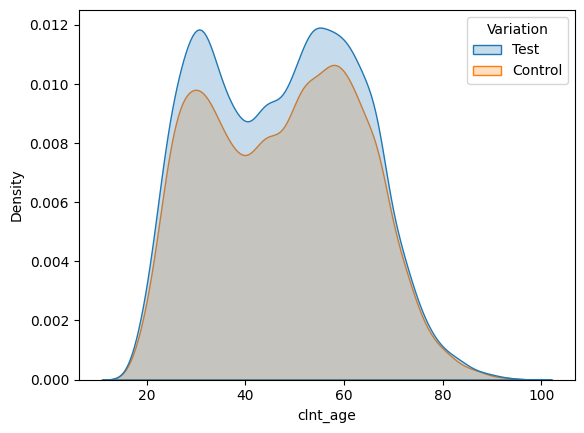

/var/folders/yf/ydfr37g56sb7b4mncpm76gk00000gn/T/ipykernel_72976/3279976592.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(test_metrics, x=col, hue = 'Variation',  shade=True)


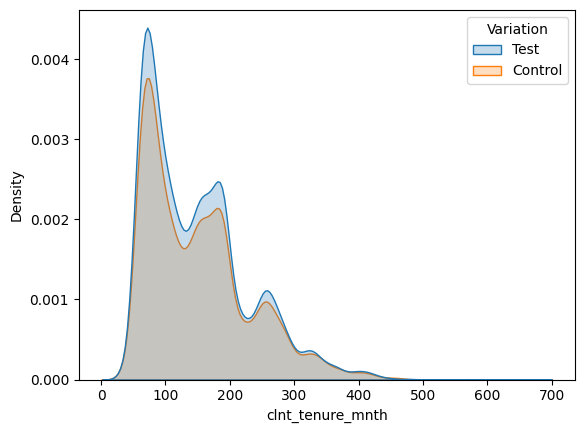

/var/folders/yf/ydfr37g56sb7b4mncpm76gk00000gn/T/ipykernel_72976/3279976592.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(test_metrics, x=col, hue = 'Variation',  shade=True)


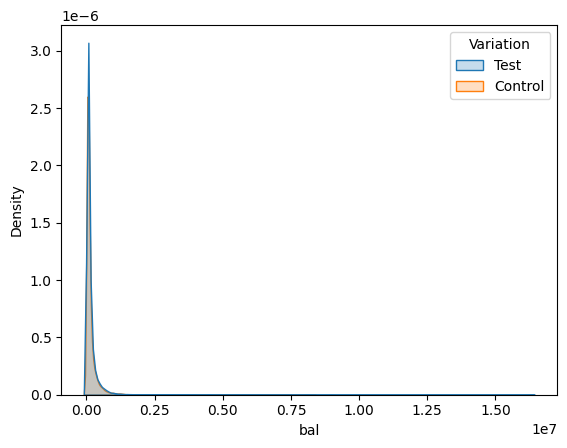

/var/folders/yf/ydfr37g56sb7b4mncpm76gk00000gn/T/ipykernel_72976/3279976592.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(test_metrics, x=col, hue = 'Variation',  shade=True)


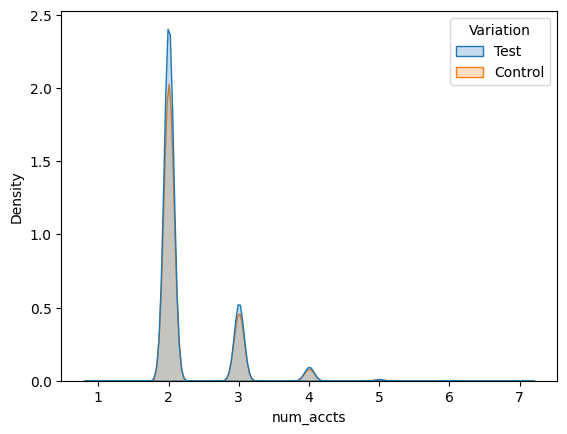

/var/folders/yf/ydfr37g56sb7b4mncpm76gk00000gn/T/ipykernel_72976/3279976592.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(test_metrics, x=col, hue = 'Variation',  shade=True)


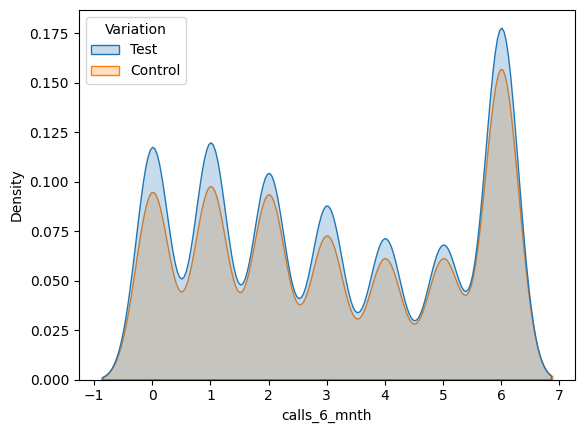

/var/folders/yf/ydfr37g56sb7b4mncpm76gk00000gn/T/ipykernel_72976/3279976592.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(test_metrics, x=col, hue = 'Variation',  shade=True)


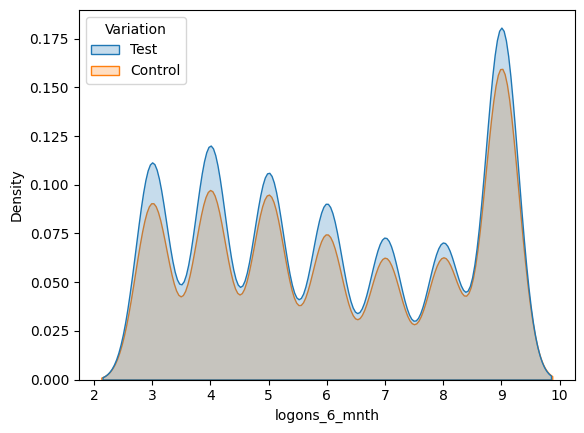

In [83]:
# let's take a look at the distributions for each group: 
for col in ['clnt_age', 'clnt_tenure_mnth', 'bal', 'num_accts', 'calls_6_mnth', 'logons_6_mnth']:
    sns.kdeplot(test_metrics, x=col, hue = 'Variation',  shade=True)
    plt.show()

# all the distributions look equivalent for both groups. 

#### Compare test behaviour

In [84]:
test_metrics.head()

df_test = test_metrics[test_metrics['Variation'] == 'Test']
df_control = test_metrics[test_metrics['Variation'] == 'Control']

In [85]:
test_metrics.columns

Index(['client_id', 'Variation', 'clnt_tenure_yr', 'clnt_tenure_mnth',
       'clnt_age', 'gendr', 'num_accts', 'bal', 'calls_6_mnth',
       'logons_6_mnth', 'last_step', 'conversion', 'event_count',
       'avg_step_time', 'return_count', 'total_conversions', 'total_visits',
       'total_time_spent', 'return_rate'],
      dtype='object')

In [86]:
# 1 CONVERSION
# 1.1 CONVERSION RATE PER USER
# Let's compare the conversion rate (how many users converted), using a proportions test. 

# H0: conversions_test = conversions_control
# H1: conversions_test > conversions_control

proportion_test(df_test, df_control, 'conversion')

proportion test 0.6916178898394116 
proportion control 0.6552345022721426
p-value:  2.3335254477448123e-18
We reject the null hypothesis. 
The proportion of the alternative is significantly larger


In [87]:
# 2 ERRORS
# 2.1 BOUNCE RATE
# Let's analyse the bouce rate for test and control. We'll use a proportions test. 

# H0: br_test = br_control
# H1: br_test < br_control

proportion_test(df_test.isna(), df_control.isna(), 'avg_step_time', alternative = 'smaller')

proportion test 0.05245384961728951 
proportion control 0.10104604304209895
p-value:  3.181440637759067e-94
We reject the null hypothesis. 
The proportion of the alternative is significantly smaller


In [88]:
test_metrics[test_metrics['Variation']== 'Control'].head()['return_rate'].mean()

np.float64(0.109281045751634)

In [89]:
## 2.2 RETURN RATE
# Let's analyse the return rate for test and control. We'll use a t-test. 

# H0: er_test = er_control
# H1: er_test < er_control

ttest(df_test, df_control, 'return_rate')

# this was unexpected: the proportion of users that return to the previous step is higher on the test. 
# perhaps this helped users finished the process by adding more flexibility. 

We reject the null hypothesis. 
The return_rate is significantly greater in the test
test mean:  0.06509075698519129
control mean:  0.04610944264123014
p-value:  1.072354014463245e-107


In [90]:
## 2.3 TIME PER STEP
# Let's analyse the time per step for test and control. We'll use a t-test. 

print('avg_step_time')
ttest(df_test.dropna(), df_control.dropna(), 'avg_step_time', alternative='less')

avg_step_time
We reject the null hypothesis. 
The avg_step_time is significantly less in the test
test mean:  78.11249564971557
control mean:  80.02473232175345
p-value:  0.015966299425046796


In [91]:
# 3 SUCCCES METRICS
# Let's compare the total time spent, total conversions, avg time per step and nr of visits for the test and control groups. We'll use a t-test.

# 3.1 TOTAL CONVERSIONS
# We want to compare the total conversions for the test and control groups. We'll use a t-test.

# H0: total_conversions_test <= total_conversions_control
# H1: total_conversions_test > total_conversions_control


for metric in ['last_step', 'total_conversions', 'event_count', 'total_time_spent', 'total_visits']:
    print(metric)
    ttest(df_test, df_control, metric)
    print(" ")




last_step
We reject the null hypothesis. 
The last_step is significantly greater in the test
test mean:  3.2182200210115566
control mean:  3.057789591014319
p-value:  6.113910352248427e-37
 
total_conversions
We reject the null hypothesis. 
The total_conversions is significantly greater in the test
test mean:  0.8272549902446346
control mean:  0.7055217354025551
p-value:  8.329275669832198e-82
 
event_count
We reject the null hypothesis. 
The event_count is significantly greater in the test
test mean:  6.576316974335885
control mean:  5.982508788476379
p-value:  3.8827833509810936e-61
 
total_time_spent
We reject the null hypothesis. 
The total_time_spent is significantly greater in the test
test mean:  441.8244409425184
control mean:  389.2613821486753
p-value:  5.202405227269751e-17
 
total_visits
We cannot reject the null hypothesis. 
 The total_visits is not significantly greater in the test
test mean:  1.3782080144079243
control mean:  1.3703163851496185
p-value:  0.14205976336611

#### Visualisations

/var/folders/yf/ydfr37g56sb7b4mncpm76gk00000gn/T/ipykernel_72976/2403827861.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_metrics_n = test_metrics.replace({'Test': 1, 'Control':0})
/var/folders/yf/ydfr37g56sb7b4mncpm76gk00000gn/T/ipykernel_72976/2403827861.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_metrics_n = test_metrics_n.replace({True: 1, False:0})


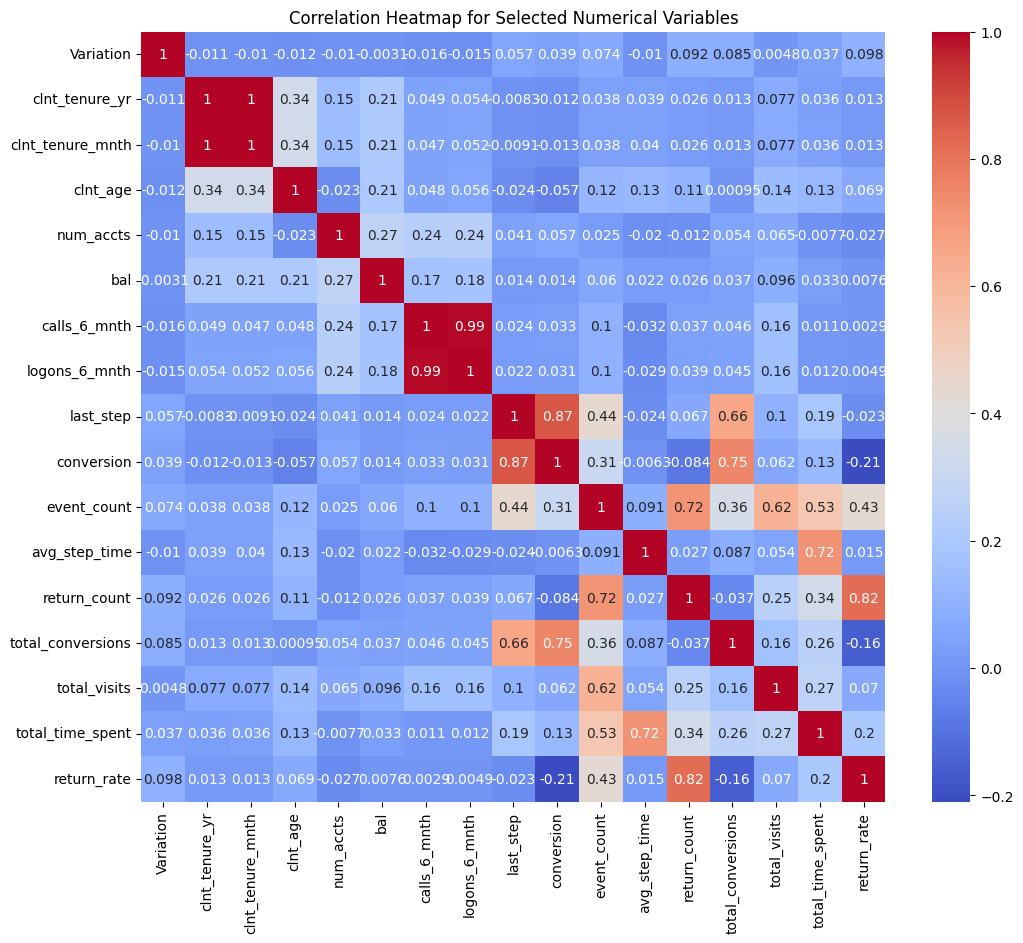

In [96]:
# Change binary values to 0 and 1
test_metrics_n = test_metrics.replace({'Test': 1, 'Control':0})
test_metrics_n = test_metrics_n.replace({True: 1, False:0})

# Give the columns with number values
test_metrics_numerical = test_metrics_n.select_dtypes("number").loc[:, test_metrics_n.select_dtypes("number").nunique() < 1000000]
test_metrics_numerical.drop(columns = 'client_id', inplace=True)


# correlation matrix. 
correlation_matrix = test_metrics_numerical.corr()

# Setting up the matplotlib figure with an appropriate size
plt.figure(figsize=(12, 10))

sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")

plt.title("Correlation Heatmap for Selected Numerical Variables")
plt.show()

<Axes: xlabel='total_conversions', ylabel='proportion'>

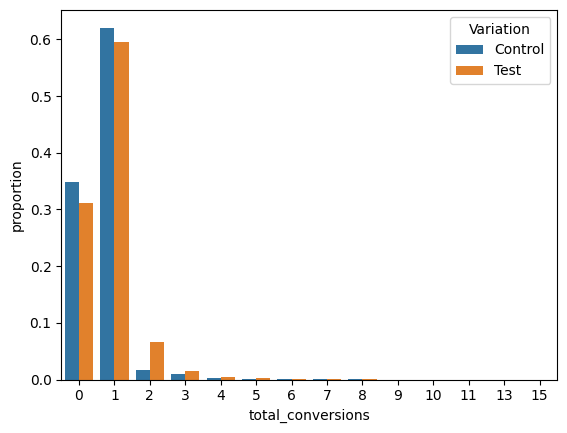

In [97]:
# Conversion nr distribution for test and control. 

df1 = test_metrics.groupby('Variation')['total_conversions'].value_counts(normalize = True).reset_index()
sns.barplot(data=df1, x='total_conversions', y='proportion', hue='Variation')

<Axes: xlabel='last_step', ylabel='proportion'>

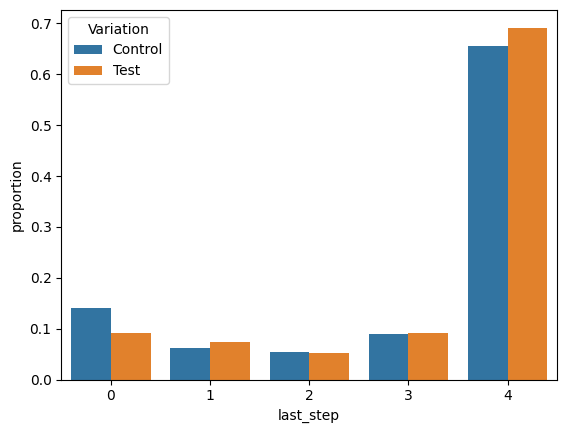

In [93]:
# last step distribution for test and control.

df1 = test_metrics.groupby('Variation')['last_step'].value_counts(normalize = True).reset_index()
sns.barplot(data=df1, x='last_step', y='proportion', hue='Variation')


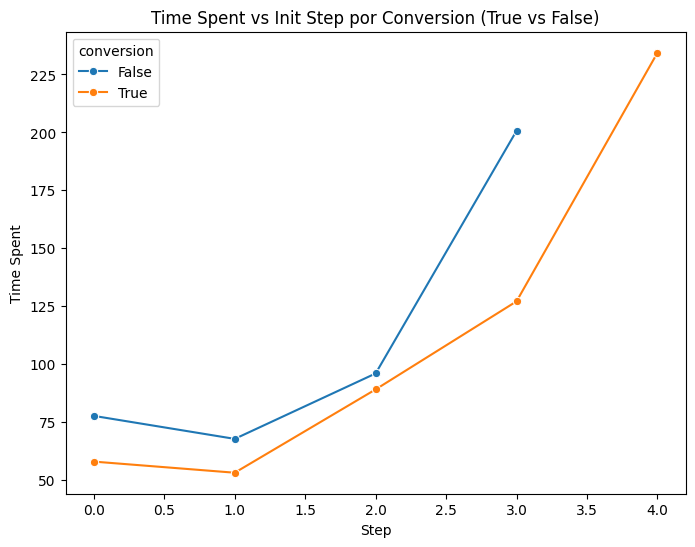

In [102]:
mean_time_step_by_conversion = test_events.groupby(['conversion', 'init_step'])['time_spent'].mean().reset_index()
plt.figure(figsize=(8,6))
sns.lineplot(data=mean_time_step_by_conversion, x='init_step', y='time_spent', hue='conversion', marker='o')

plt.title('Time Spent vs Init Step por Conversion (True vs False)')
plt.xlabel('Step')
plt.ylabel('Time Spent')

plt.show()

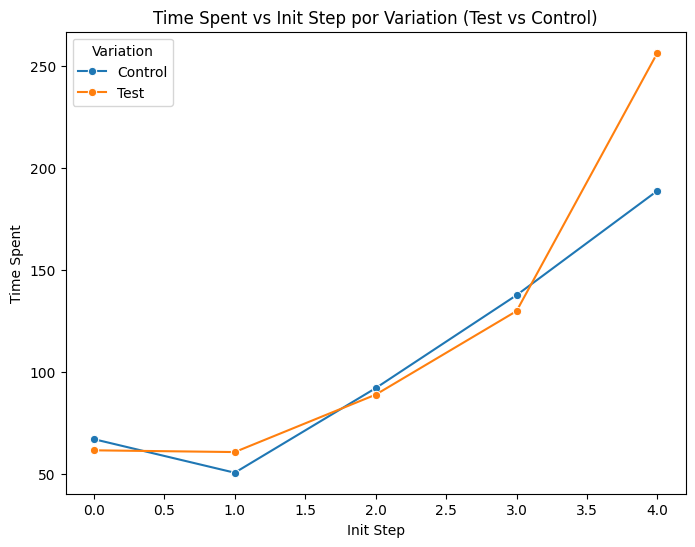

In [104]:
mean_time_step_by_variation = test_events.groupby(['Variation', 'init_step'])['time_spent'].mean().reset_index()
plt.figure(figsize=(8,6))
sns.lineplot(data=mean_time_step_by_variation, x='init_step', y='time_spent', hue='Variation', marker='o')

plt.title('Time Spent vs Init Step por Variation (Test vs Control)')
plt.xlabel('Init Step')
plt.ylabel('Time Spent')

plt.show()